In [7]:
import numpy as np
import matplotlib.pyplot as plt
from optic.dsp.core import pulseShape

# Canal Óptico

O canal de comunicação óptica é o resultado de diversas interações entre sinais ópticos e matéria. Esses efeitos podem ocorrer nas diversas seções de fibra óptica do link ou nos dispositivos atravessados pelo sinal óptico. 

O efeito mais fundamental para qualquer sistema de comunicação é atenuação, que reduz a potência do sinal ao longo do link como resultado de fenômenos de absorção e espalhamento. Devido à atenuação, os sinais transmitidos precisam ser amplificados periodicamente por amplificadores em linha, que inserem ruído e limitam o alcance do sistema.

Neste notebook não iremos abordar todos esses efeitos, mas apenas aqueles mais significativos para a modelagem de sistemas ópticos digitais coerentes.

### 3.2 Chromatic Dispersion

A dispersão do modo de polarização (*Polarization mode dispersion* - PMD) e a dispersão cromática (*Chromatic Dispersion* - CD) são dois efeitos lineares importantes que espalham símbolos ao longo do tempo e causam interferência. Eles geralmente são compensados no receptor usando usando tecnicas de processamento digital de sinais (DSP) Embora o PMD e o CD individualmente não limitem a capacidade, eles influenciam a complexidade do DSP do receptor, pois o CD pode exigir equalizadores estáticos muito longos e o PMD exige equalização adaptativa.

Neste tópico estamos interessados em transmitir informações através de fibras ópticas. A informação é transmitida apenas por pacotes de frequências, formando um padrão que viaja pela fibra com velocidade de grupo $v_g$

$$v_{g}=\left({\frac{d\beta}{d\omega}}\right)^{-1}$$

onde $\beta$ é a constante de propagação. Outro conceito necessário para entendermos esse fenômeno é a velocidade de fase $v_p$ de um sinal senoidal com frequência $\omega$ dado por

$$\ v_{p}={\frac{\omega}{\beta}}$$

Se a constante de propagação tiver uma dependência linear com a frequência, então $v_g = v_p$, qualquer grupo de frequências de propagação terá a mesma velocidade de grupo e os pulsos não serão distorcidos. É o caso, por exemplo, das ondas planas que viajam no espaço livre. Entretanto, em guias de onda práticos, a constante de propagação $\beta$ tem uma dependência não linear de $\omega$. Assim, diferentes componentes espectrais de um modo guiado se propagam com velocidades de grupo distintas, dando origem ao fenômeno conhecido como CD.

Se não for compensado, o CD amplia os pulsos de propagação e leva à interferência intersimbólica (ISI), como mostrado na figura abaixo que demostra o efeito do CD na propagação do sinal. CD espalha os pulsos no tempo, levando à interferência intersimbólica (ISI)

<br>
<center>
    <img src="https://i.postimg.cc/6pYm6pmx/Dispers-o.png">
</center>
<br>

Considerando um guia de ondas sem perdas, os componentes de um campo elétrico ou magnético de frequência $\omega$ variam na direção de propagação no eixo $z$ de acordo com

$$E(z,\omega)=E(0,\omega)e^{-j\beta(\omega)z}$$

onde $\beta(w)$ é a constante de propagação em $\omega$. A mesma análise pode ser realizada para os componentes de frequência do espectro ${\tilde{A}}\left(z,\,0\right)$ do sinal $A(z, t)$, expandindo $\beta(\omega)$ na série de Taylor em torno da frequência angular da portadora $\omega_c$

$$\tilde{A}(z,\omega)=\tilde{A}(0,\omega)e^{-j\beta(\omega)z}$$
$$\tilde{A}(z,\omega)=\tilde{A}(0,\omega)e^{-\Big(j\beta_{0}+j\beta_{1}\Delta\omega+\frac{j\beta_{2}}{2}\Delta\omega^{2}+\ldots\Big)z}$$

Onde $\beta_i$ é a i-ésima derivada de $\beta$ em relação a $\omega$, e $\Delta\omega=\omega-\omega_{c}.$ O termo $e^{j\beta_{0}z}$ é uma mudança de fase. A multiplicação por $e^{j\beta_{1}\Delta\omega z}$ gera um deslocamento de tempo de um pulso não distorcido. 

A dispersão cromática está relacionada ao termo $e^{\frac{\beta_{2}}{2}\Delta\omega^{2}z}$. Para um observador viajando com o pulso, o espectro de um sinal corrompido por CD pode ser calculado como

$$\tilde{A}(z,\omega)=\tilde{A}(0,\omega)e^{-\frac{j\beta_{2}z}{2}\Delta\omega^{2}}$$

Podemos observar o efeito de disperção como um filtro passa tudo que modifica apenas a fase do nosso sinal, onde a amplitude e mantida constante.

O parâmetro $\beta_2$ tem unidades de $s/m/[rad/s]$ e fornece a dispersão dos pulsos (em segundos) por unidade de comprimento de fibra (em metros) e por unidade de largura de banda espectral (em radianos por segundo). Na especificação de fibras ópticas, entretanto, a dispersão é geralmente quantificado pelo parâmetro de dispersão de velocidade de grupo (GVD), D, em unidades de $s/m2$, ou melhor, em $ps/nm/km$. O parâmetro GVD indica a propagação do pulso (em picossegundos), por unidade de distância (em quilômetros), por unidade de largura de banda espectral (em nanômetros).

### Simulação do impacto da dispersão na fibra

vamos reproduzir o efeito de dispersão na fibra partindo da função de transferência do canal.

In [64]:
# parâmetros da simulação
Fa = 256                                       # Frequência de amostragem
NFFT = 1024                                    # Tamanho da FFT
freq = Fa/NFFT * np.arange(-NFFT/2, NFFT/2)    # Intervalo de frequências
beta2 = 20e-6                                  # Parâmetro GVD
z = 150                                        # Distância de propagação [comprimento da fibra em metros]

In [66]:
H  = np.exp(1j*0.5*beta2*z*(2*np.pi*freq)**2) # Função de transferência do canal

Observe que apenas a fase é alterada, a amplitude se mantém constante.

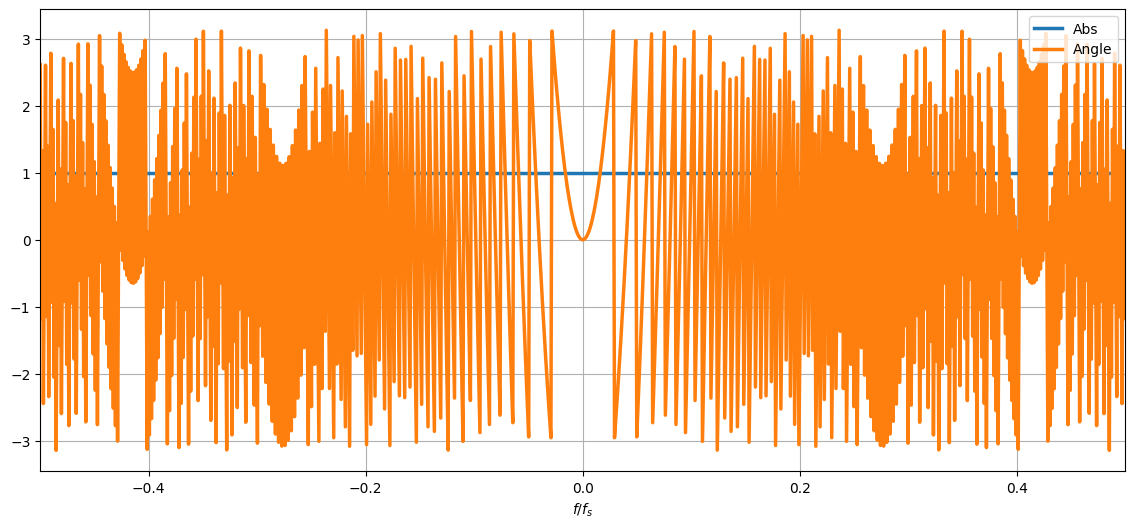

In [74]:
fig = plt.figure(figsize=(14, 6))
#plt.plot(f/fs, H.real, f/fs, H.imag)
plt.plot(freq/Fa, abs(H), freq/Fa, np.angle(H), linewidth=2.5)
plt.xlabel(r'$f/f_s$')
plt.xlim([-0.5, 0.5])
#plt.legend(['Real', 'Imag'], loc = 'upper right')
plt.legend(['Abs', 'Angle'], loc = 'upper right')
plt.grid(True)

### Definindo um pulso para propagação na fibra

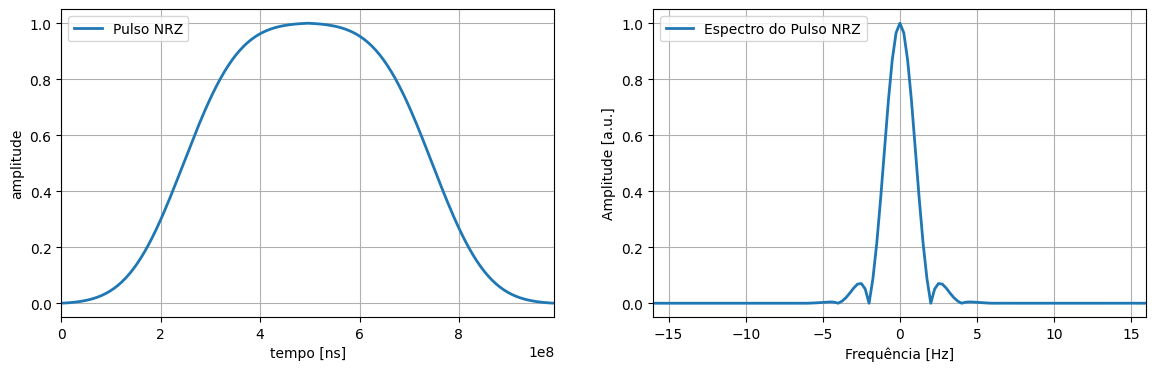

In [57]:
PulseType = 'nrz'
pulse = pulseShape(PulseType, 128)
pulse = pulse/max(abs(pulse))

# define o espectro do pulso normalizado
PulseFFT = np.abs(np.fft.fftshift(np.fft.fft(pulse, NFFT)))
PulseFFT = PulseFFT/max(abs(PulseFFT))

t = np.arange(pulse.size)*((1/Fa)/1e-9) # tempo em nano segundos amostrados em Ta

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(t, pulse, '-', linewidth=2, label='Pulso '+str(PulseType.upper()))
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left')
axs[0].grid(True);

axs[1].plot(freq, PulseFFT, '-', linewidth=2, label='Espectro do Pulso '+str(PulseType.upper()))
axs[1].set_xlabel('Frequência [Hz]')
axs[1].set_ylabel('Amplitude [a.u.]')
axs[1].set_xlim(min(freq/8), max(freq/8))
axs[1].legend(loc='upper left')
axs[1].grid(True);

In [54]:
# realizando a resposta ao impulso do canal
PH = PulseFFT*H
# realiza tranformada inversa de Fourier para determinar o sinal resultante.
ph = np.fft.ifftshift(np.fft.ifft(PH))
phR = T0/np.sqrt(T0**2-1j*beta2*z) * np.exp(-(t**2)/(2*(T0**2-1j*beta2*z)))